In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
GPU_ID= '0'
os.environ["CUDA_VISIBLE_DEVICES"] =GPU_ID
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

In [2]:
import keras
# ^^^ pyforest auto-imports - don't write above this line
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
import numpy as np

Using TensorFlow backend.
D:\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\python36\lib\site-packages\tensorflow\python\framework\d

In [3]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min))

In [23]:
# ^^^ pyforest auto-imports - don't write above this line
# load and prepare training images
def load_real_samples(training_patches):
    # load compressed arrays
    X1= np.zeros((len(training_patches),256,256,4))
    X2= np.zeros((len(training_patches),256,256,8))
    for i,(filename) in enumerate(training_patches):
        data = np.load(filename)
        # unpack arrays
        redn = normalize(data[:, :, 0])
        greenn = normalize(data[:, :, 1])
        bluen = normalize(data[:, :, 2])
        infraredn = normalize(data[:, :, 3])
        X1[i] = np.dstack((redn, greenn, bluen,infraredn))
        #X2[i] = np.copy(np.expand_dims(data[:, :, 5],axis=2))
        y_train_hr = np.copy(data[:, :, 5])
        y_train_hr[y_train_hr == 1] = 0
        y_train_hr[y_train_hr == 2] = 1
        y_train_hr[y_train_hr == 4] = 2
        y_train_hr[y_train_hr == 5] = 3
        y_train_hr[y_train_hr == 6] = 4
        y_train_hr[y_train_hr == 7] = 5
        y_train_hr[y_train_hr == 9] = 6
        y_train_hr[y_train_hr == 10] = 7
        y_train_hr = keras.utils.to_categorical(y_train_hr, 8)
        X2[i] = y_train_hr
    return [X1, X2]

In [24]:
validation_patches=["..\SEN12MS\processed\ROIs13_high_roshan_s2_val_patches\ROIs13_high_roshan\s2_1\ROIs0000_validation_s2_0_p0.npy"]
# load dataset
[X1, X2] = load_real_samples(validation_patches)

In [25]:
model = load_model('model_104000.h5')

In [26]:
#selecting a random exmaple
ix = randint(0, len(X1), 1)
print(ix)
src_image, tar_image = X1[ix], X2[ix]

[0]


In [27]:
print(ix)
print(src_image.shape)

[0]
(1, 256, 256, 4)


In [28]:
gen_image = model.predict(src_image)

In [29]:
lab2rgb = {0:[0./255, 128./255, 0./255],        #dark-green         ->          Forest
           1:[205./255, 133./255, 63./255],     #peruvian-brown     ->          Dense-Shrublands
           2:[224./255, 216./255, 202./255],    #savana-oaks        ->          Woody-Savanas
           3:[102./255, 102./255, 25./255],    #dark-olive         ->          Grasslands
           4:[210./255, 209./255, 205./255],   #concrete           ->          Urban
           #5:[229./255, 229./255, 178./255],   #pale-olive         ->          Vegetation
           5:[255./255, 255./255, 255./255],   #white              ->          Snow-and-ice
           6:[131./255, 117./255, 96./255],    #barren-paint       ->          Barren
           7:[135./255, 206./255, 250./255],   #light-blue         ->          Water-bodies
          }
rgb = np.ones((256,256,3))

In [30]:
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    #images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    #images = (images + 1) / 2.0
    #titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    
    n_samples =1
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(src_img[i])
    # plot generated target image
    for i in range(n_samples):
        label = np.argmax(gen_img[i], axis=-1)
        for p in range(256):
            for q in range(256):
                rgb[p,q,:] = np.expand_dims(np.array(lab2rgb[label[p,q]]),axis=0)
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(rgb)
    # plot real target image
    for i in range(n_samples):
        label = np.argmax(tar_img[i], axis=-1)
        for p in range(256):
            for q in range(256):
                rgb[p,q,:] = np.expand_dims(np.array(lab2rgb[label[p,q]]),axis=0)
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(rgb)

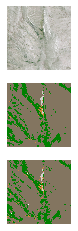

In [31]:
plot_images(src_image, gen_image, tar_image)